In [1]:
# Import required libraries for data handling, API connections, and model training
import os
import re
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
import matplotlib.pyplot as plt
from datasets import load_dataset
import numpy as np
import pickle
from collections import Counter
from openai import OpenAI

In [3]:
# Load API keys from .env file
load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', '####-####-####-####')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', '####-####-####-####')

In [4]:
# Initialize OpenAI client and login to HuggingFace
openai = OpenAI()

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


# Step 1

### Prepare our data for fine-tuning in JSONL (JSON Lines) format and upload to OpenAI

### Load and Cache Dataset
Download banking77 dataset or load from cache (for slow internet)


In [5]:
from data_cleaner import clean_dataset

# Check if pickle files exist, otherwise download
if os.path.exists('train.pkl') and os.path.exists('test.pkl'):
    print("Loading from cached pickle files...")
    with open('train.pkl', 'rb') as f:
        train = pickle.load(f)
    with open('test.pkl', 'rb') as f:
        test = pickle.load(f)
    print(f"✓ Loaded {len(train)} train and {len(test)} test samples from cache")
else:
    print("✓ Downloading dataset from HuggingFace...")
    dataset = load_dataset("PolyAI/banking77")
    
    # Clean the data
    print("Cleaning dataset...")
    train = clean_dataset(dataset['train'], min_length=10, max_samples_per_intent=200)
    test = clean_dataset(dataset['test'], min_length=10)
    
    # Save for next time
    with open('train.pkl', 'wb') as f:
        pickle.dump(train, f)
    with open('test.pkl', 'wb') as f:
        pickle.dump(test, f)
    print(f"✓ Cleaned and saved {len(train)} train and {len(test)} test samples")

Loading from cached pickle files...
✓ Loaded 10003 train and 3080 test samples from cache


# Step 2

### Create fine-tuning job on OpenAI and monitor training progress

In [6]:
# Convert to list format for easier handling
train_list = [{'text': train[i]['text'], 'label': train[i]['label']} for i in range(len(train))]

# Create fine-tuning subsets
fine_tune_train = train_list[:200] #800
fine_tune_validation = train_list[200:250] #4,000

print(f"✓ Created {len(fine_tune_train)} train and {len(fine_tune_validation)} validation examples")

✓ Created 200 train and 50 validation examples


### Format Messages for OpenAI
Create training and inference message formats


In [7]:
from banking_intents import get_intent

def messages_for_training(item):
    """Create messages for fine-tuning - includes the correct answer"""
    system_message = "You classify banking customer queries into intents. Reply only with the intent name, no explanation"
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": item['text']},
        {"role": "assistant", "content": get_intent(item['label'])}
    ]

def messages_for_inference(item):
    """Create messages for prediction - NO answer (model must predict)"""
    system_message = "You classify banking customer queries into intents. Reply only with the intent name, no explanation"
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": item['text']}
    ]

# Test training format
messages_for_training(train[0])

[{'role': 'system',
  'content': 'You classify banking customer queries into intents. Reply only with the intent name, no explanation'},
 {'role': 'user', 'content': 'I am still waiting on my card?'},
 {'role': 'assistant', 'content': 'card_arrival'}]

In [8]:
def make_jsonl(data, start=0, end=None):
    """Convert data to JSONL format for training"""
    result = ""
    end = end or len(data)
    
    for i in range(start, end):
        item = data[i]
        messages = messages_for_training(item)  # Use training format
        messages_str = json.dumps(messages)
        result += '{"messages": ' + messages_str +'}\n'
    
    return result.strip()

print(make_jsonl(train, start=0, end=3))

{"messages": [{"role": "system", "content": "You classify banking customer queries into intents. Reply only with the intent name, no explanation"}, {"role": "user", "content": "I am still waiting on my card?"}, {"role": "assistant", "content": "card_arrival"}]}
{"messages": [{"role": "system", "content": "You classify banking customer queries into intents. Reply only with the intent name, no explanation"}, {"role": "user", "content": "What can I do if my card still hasn't arrived after 2 weeks?"}, {"role": "assistant", "content": "card_arrival"}]}
{"messages": [{"role": "system", "content": "You classify banking customer queries into intents. Reply only with the intent name, no explanation"}, {"role": "user", "content": "I have been waiting over a week. Is the card still coming?"}, {"role": "assistant", "content": "card_arrival"}]}


### Convert to JSONL and Upload
Prepare data in OpenAI format and upload to their servers


In [9]:

# Write JSONL string to file
def write_jsonl(data, filename, start=0, end=None):
    with open(filename, "w") as f:
        jsonl = make_jsonl(data, start, end)
        f.write(jsonl)

In [10]:
# Verify data loaded correctly - show first 3 examples
for i in range(3):
    print(f"{i}. {train[i]['text']} → Intent: {train[i]['label']}")

0. I am still waiting on my card? → Intent: 11
1. What can I do if my card still hasn't arrived after 2 weeks? → Intent: 11
2. I have been waiting over a week. Is the card still coming? → Intent: 11


In [11]:
def prepare_and_upload(data, filename):
    """Write JSONL and upload to OpenAI"""
    write_jsonl(data, filename)
    with open(filename, "rb") as f:
        return openai.files.create(file=f, purpose="fine-tune")

# Use it
train_file = prepare_and_upload(fine_tune_train, "fine_tune_train.jsonl")
validation_file = prepare_and_upload(fine_tune_validation, "fine_tune_validation.jsonl")

print(f"✓ Uploaded train: {train_file.id}")
print(f"✓ Uploaded validation: {validation_file.id}")

✓ Uploaded train: file-U84ceTSvNn833d6aPpWX4i
✓ Uploaded validation: file-ARVTnFJnHn2HpE9UAr9mr5


In [12]:
# Create fine-tuning job - training happens on OpenAI's servers
openai.fine_tuning.jobs.create(
    training_file=train_file.id,
    validation_file=validation_file.id,
    model="gpt-4o-mini-2024-07-18",
    seed=42,  # For reproducibility
    hyperparameters={"n_epochs": 1},  # Training passes
    suffix="banking_intent"  # Custom model name
)

FineTuningJob(id='ftjob-FN3B5dQQOhuk4UVOZ5X4CqBU', created_at=1761873619, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-OFfqVJ5fIDV1i5BqCwT86Px6', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-U84ceTSvNn833d6aPpWX4i', validation_file='file-ARVTnFJnHn2HpE9UAr9mr5', estimated_finish=None, integrations=[], metadata=None, method=Method(type='supervised', dpo=None, reinforcement=None, supervised=SupervisedMethod(hyperparameters=SupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1))), user_provided_suffix='banking_intent', usage_metrics=None, shared_with_openai=False, eval_id=None)

### Monitor Training Progress
Check job status and view training events


In [20]:
# List most recent fine-tuning job to check status
job = openai.fine_tuning.jobs.list(limit=1).data[0]
print(f"Status: {job.id}")
print(f"Status: {job.status}")

Status: ftjob-FN3B5dQQOhuk4UVOZ5X4CqBU
Status: succeeded


In [21]:
# Get detailed information about the job
openai.fine_tuning.jobs.retrieve(job.id)

FineTuningJob(id='ftjob-FN3B5dQQOhuk4UVOZ5X4CqBU', created_at=1761873619, error=Error(code=None, message=None, param=None), fine_tuned_model='ft:gpt-4o-mini-2024-07-18:hope-ogbons:banking-intent:CWYGwKT5', finished_at=1761874273, hyperparameters=Hyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-OFfqVJ5fIDV1i5BqCwT86Px6', result_files=['file-N5eUNWYhwaxJt2KSYEjpBU'], seed=42, status='succeeded', trained_tokens=9105, training_file='file-U84ceTSvNn833d6aPpWX4i', validation_file='file-ARVTnFJnHn2HpE9UAr9mr5', estimated_finish=None, integrations=[], metadata=None, method=Method(type='supervised', dpo=None, reinforcement=None, supervised=SupervisedMethod(hyperparameters=SupervisedHyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=1))), user_provided_suffix='banking_intent', usage_metrics=None, shared_with_openai=False, eval_id=None)

In [22]:
# View training events log (last 10 events)
openai.fine_tuning.jobs.list_events(fine_tuning_job_id=job.id, limit=10).data

[FineTuningJobEvent(id='ftevent-nsKcQzrX5kAlH71815ndMGr4', created_at=1761875045, level='info', message='The job has successfully completed', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-BWM8ClTEEWO3rVf1bn8WdszY', created_at=1761875039, level='info', message='Usage policy evaluations completed, model is now enabled for sampling', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-yyxA2AU1GvpP5Ii3WbxlDktc', created_at=1761875039, level='info', message='Moderation checks for snapshot ft:gpt-4o-mini-2024-07-18:hope-ogbons:banking-intent:CWYGwKT5 passed.', object='fine_tuning.job.event', data={'blocked': False, 'results': [{'flagged': False, 'category': 'harassment/threatening', 'enforcement': 'blocking'}, {'flagged': False, 'category': 'sexual', 'enforcement': 'blocking'}, {'flagged': False, 'category': 'sexual/minors', 'enforcement': 'blocking'}, {'flagged': False, 'category': 'propaganda', 'enforcement':

# Step 3

### Use the fine-tuned model to classify banking queries

In [23]:
# Get the fine-tuned model ID (only works after training succeeds)
fine_tuned_model_name = openai.fine_tuning.jobs.retrieve(job.id).fine_tuned_model
fine_tuned_model_name

'ft:gpt-4o-mini-2024-07-18:hope-ogbons:banking-intent:CWYGwKT5'

### Use Fine-Tuned Model
Classify banking queries with the trained model


In [24]:
def gpt_fine_tuned(item):
    """Classify banking query using fine-tuned model"""
    response = openai.chat.completions.create(
        model=fine_tuned_model_name,
        messages=messages_for_inference(item),  # Use inference format (no label)
        seed=42,
        max_tokens=20
    )
    intent = response.choices[0].message.content.strip()
    return intent

gpt_fine_tuned(train[0])

'card_arrival'

In [25]:
# Verify training completed successfully
print("Model name:", fine_tuned_model_name)
print()

print("Job ID:", job.id)
job_status = openai.fine_tuning.jobs.retrieve(job.id)
print("Status:", job_status.status)
print("Fine-tuned model:", job_status.fine_tuned_model)

Model name: ft:gpt-4o-mini-2024-07-18:hope-ogbons:banking-intent:CWYGwKT5

Job ID: ftjob-FN3B5dQQOhuk4UVOZ5X4CqBU
Status: succeeded
Fine-tuned model: ft:gpt-4o-mini-2024-07-18:hope-ogbons:banking-intent:CWYGwKT5


In [26]:
# Test the fine-tuned model on a single example
print("Test example:", test[0])
print("Predicted intent:", gpt_fine_tuned(test[0]))

Test example: {'text': 'How do I locate my card?', 'label': 11}
Predicted intent: card_arrival


### Evaluate Model Performance
Test on 100 examples and calculate accuracy


In [27]:
# Convert test to list format
test_list = [{'text': test[i]['text'], 'label': test[i]['label']} for i in range(len(test))]

print(f"✓ Converted {len(test_list)} test examples to list format")


✓ Converted 3080 test examples to list format


Testing Gpt Fine Tuned on 100 examples...

✓ 1: How do I locate my card?
   Predicted: card_arrival | Actual: card_arrival
✓ 2: I still have not received my new card, I ordered over a week...
   Predicted: card_arrival | Actual: card_arrival
✓ 3: I ordered a card but it has not arrived. Help please!
   Predicted: card_arrival | Actual: card_arrival
✓ 4: Is there a way to know when my card will arrive?
   Predicted: card_arrival | Actual: card_arrival
✓ 5: My card has not arrived yet.
   Predicted: card_arrival | Actual: card_arrival
✓ 6: When will I get my card?
   Predicted: card_arrival | Actual: card_arrival
✓ 7: Do you know if there is a tracking number for the new card y...
   Predicted: card_arrival | Actual: card_arrival
✓ 8: i have not received my card
   Predicted: card_arrival | Actual: card_arrival
✓ 9: still waiting on that card
   Predicted: card_arrival | Actual: card_arrival
✓ 10: Is it normal to have to wait over a week for my new card?
   Predicted: card_arrival | Actu

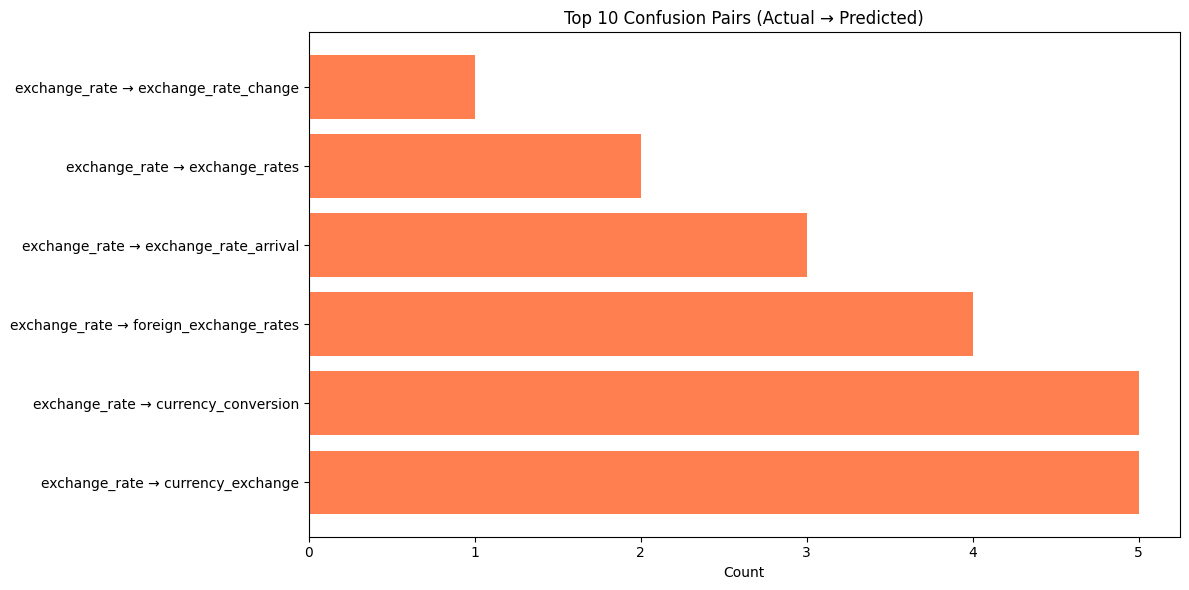

In [28]:
# Run comprehensive evaluation on 100 test examples
from classifier_tester import ClassifierTester

accuracy = ClassifierTester.test(gpt_fine_tuned, test_list, size=100)
